# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from sklearn.metrics import mean_squared_error


#### Model Parameters

In [72]:
"Parameters of the LSTM models."
LOOK_BACK = 40
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 25
EPOCHS=5
LEARN_RATE=0.001
VALIDATION_SPLIT=0.2
NUMBER_NEURONS=50
PERIOD='10y'
NUMBER_OF_LAYERS=2;

#### Loading data from Yahoo

In [43]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')

In [73]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

### EDA - Exploratory Data Analysis

In [74]:
df=load_df_portugal()
#sns.set(rc={'figure.figsize':(15.27,15.27)})

<AxesSubplot: title={'center': 'PSI20 Close Daily correlation'}, xlabel='y(t)', ylabel='y(t + 1)'>

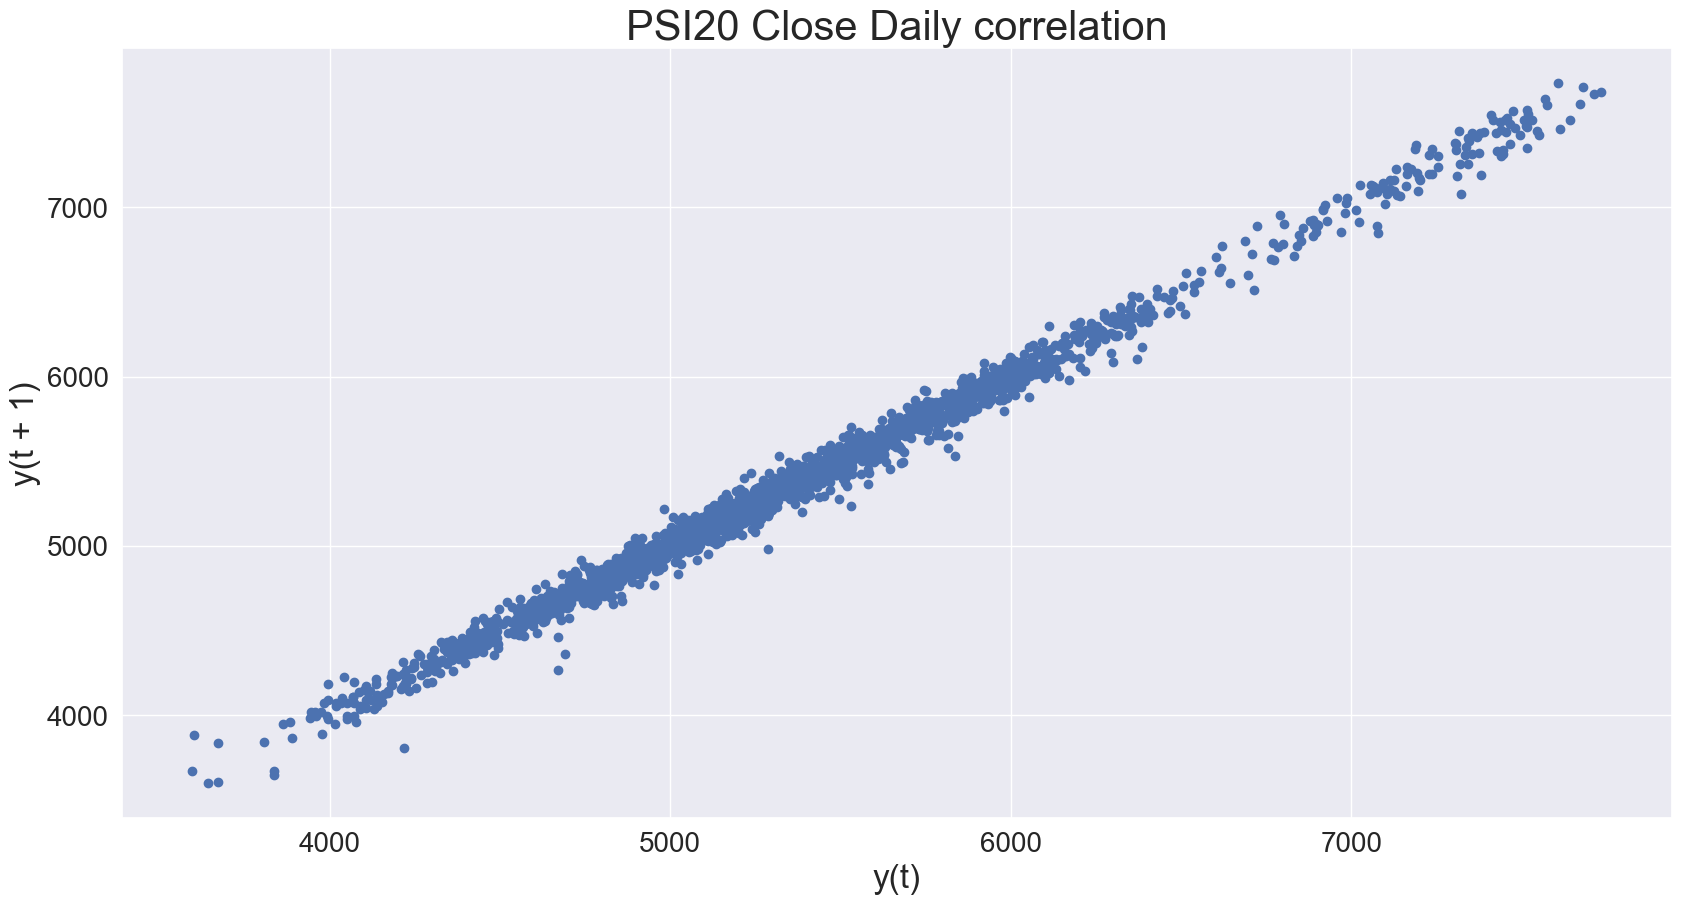

In [75]:
from pandas.plotting import lag_plot
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("PSI20 Close Daily correlation", fontsize=30)
lag_plot(df['Close'], lag=1)


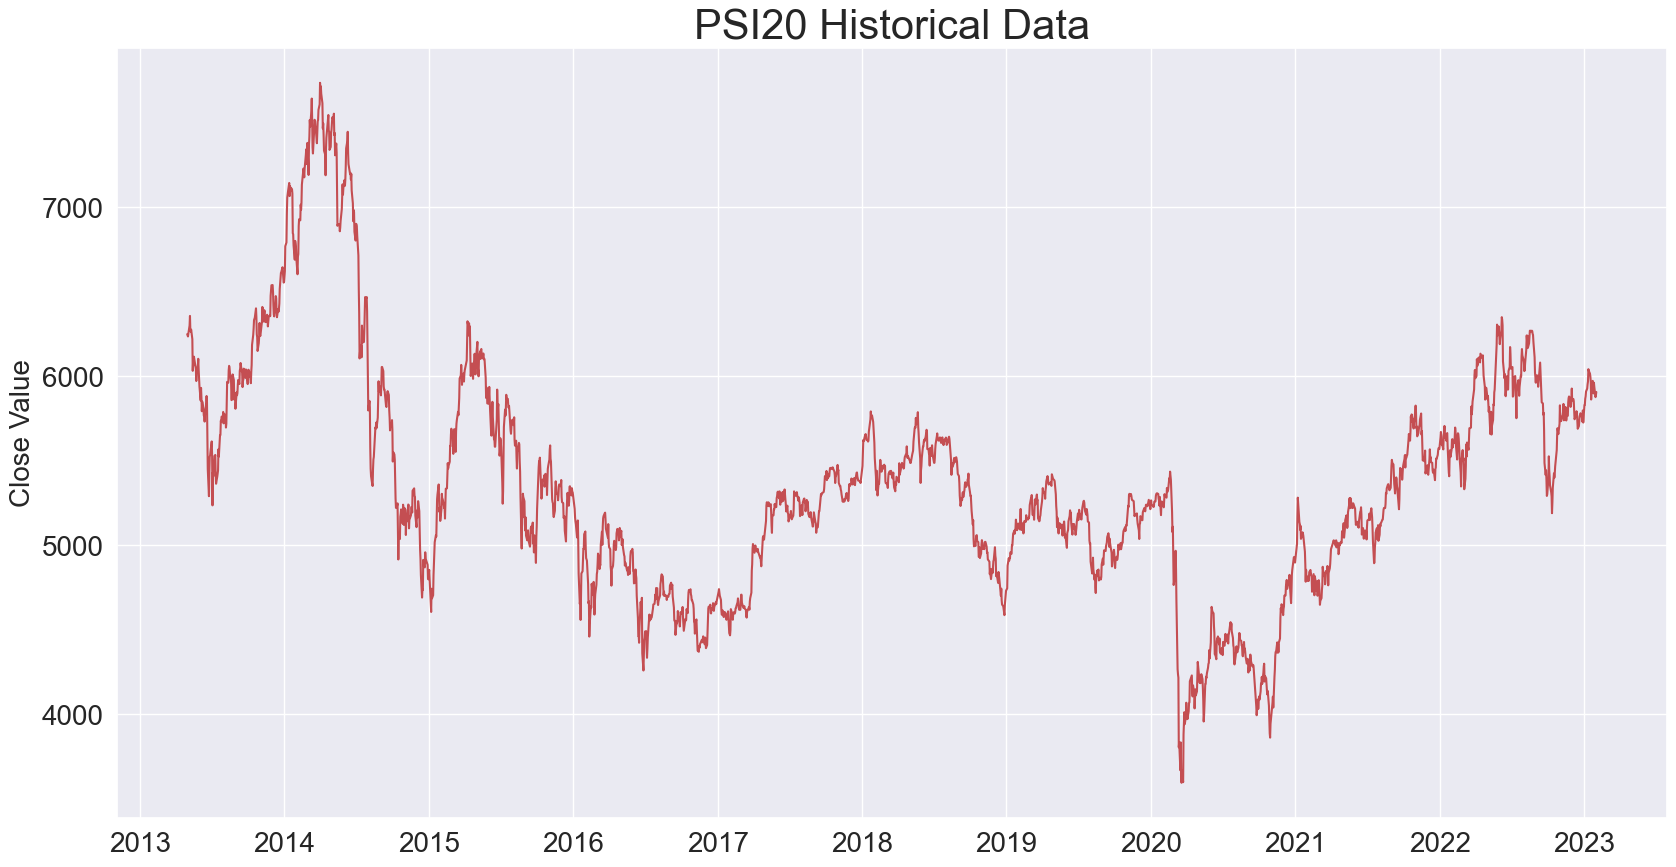

In [76]:
import seaborn as sns
plt.plot(df["Close"], 'r', label='PSI20 Daily Closing Values')
plt.title("PSI20 Historical Data", fontsize=30)
plt.ylabel('Close Value', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
import seaborn as sns
sns.set(font_scale=2)
#sns.set(rc={'figure.figsize':(15.27,15.27)})
#plt.hist(accuracies3)
#plt.show()
plt.show()  




In [48]:
df.describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1228.000000,1228.000000,1228.000000,1228.000000,1.228000e+03,1228.0,1228.0
mean,5197.101938,5227.978416,5164.300575,5195.969664,8.011948e+07,0.0,0.0
std,540.078839,539.456283,541.184158,541.032964,4.245179e+07,0.0,0.0
min,3554.699951,3613.669922,3500.020020,3596.080078,6.284000e+05,0.0,0.0
25%,4902.504883,4933.772583,4877.552368,4903.747314,5.143135e+07,0.0,0.0
50%,5218.574951,5240.354980,5191.094971,5219.030029,6.804180e+07,0.0,0.0
75%,5586.112549,5614.227417,5553.397461,5583.119873,9.607812e+07,0.0,0.0
max,6362.879883,6370.779785,6314.640137,6349.209961,3.252189e+08,0.0,0.0


## Setting the Model

##### Data Preparation

In [49]:
"Dropping unwanted columns from the data retrieved"
def selectData(datframe=df) :
    data = datframe[["Close"]]
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [50]:
# Splits Data into Train Data and Test Data
def divideData(data, size) : 
    
    train_data=data.values[0:size,:]
    test_data=data[size-LOOK_BACK:].values.reshape(-1,1)
    
    return train_data,test_data

#### Scalers

In [51]:
# Scale Data between 0 and 1 
def scaleData(data,scaler) :
    d1=data.copy()
    temp = scaler.fit_transform(d1[:, 0].reshape(-1,1))
    d1[:,0] = temp.squeeze()
    return d1
 

In [52]:
def diffLogData (data) : 
    data = np.reshape(data,(data.shape[1], data.size))
    return np.diff(np.log(data)).T
    #return np.transpose(np.diff(np.log(data)))

In [87]:
def undiffLogData (actualData, diffLoggedData) :
    "Data is the array of logarithmic Differences and v0 is the actual prices on the period"
    #TODO in the data array add a "1" on position 0. - Concatenate.
    
    temp = np.exp(np.log(actualData[:-1]) - diffLoggedData)

    return np.concatenate((actualData[0:1], temp))

#### Train/Test Vector Creators

In [54]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"
    
    x_train=[]

    for i in range(LOOK_BACK,len(data)):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [55]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [56]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, where x is the LOOK_BACK"
    
    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)
    
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

#### LSTM Model

In [57]:
#%% Creates a LSTM Sequential model
def createLstmModel (data) : 

    input_shape=(np.shape(data)[1],1)
    
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            #lstm_model.add(Dropout(0.01))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    
    # For single or multiple output (regression)
  
        lstm_model.add(Dense(units=1))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
        return lstm_model

In [58]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train,epoch=EPOCHS) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=epoch,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [59]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS", fontsize=20)
    plt.ylabel(yaxis, fontsize=20)
    plt.title(title, fontsize=30, loc="center")
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()




# == RUNNING THE MODEL ==

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [60]:
#df=df.truncate(after=pd.Timestamp('2021-08-01 00:00:00+00:00'))

global_data, size_train_data = selectData() 

train_data,test_data = divideData(global_data, size_train_data)

scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
scaled_test_data=scaleData(test_data,scaler)

x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)
X_test = createTestVector(scaled_test_data)


In [61]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.66142175 0.67301952 0.68277192 ... 0.68016764 0.69790029 0.72213088]
 [0.67301952 0.68277192 0.67909251 ... 0.69790029 0.72213088 0.7223015 ]
 [0.68277192 0.67909251 0.6870217  ... 0.72213088 0.7223015  0.7327587 ]
 ...
 [0.68698534 0.66101135 0.67120341 ... 0.80715397 0.79970062 0.77815803]
 [0.66101135 0.67120341 0.6498277  ... 0.79970062 0.77815803 0.78817202]
 [0.67120341 0.6498277  0.61613505 ... 0.77815803 0.78817202 0.78821565]]

y data - target

[[0.7223015 ]
 [0.7327587 ]
 [0.7368086 ]
 ...
 [0.78817202]
 [0.78821565]
 [0.8174441 ]]


In [62]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data, epoch = 5)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 50)            10400     
                                                                 
 lstm_7 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
37/37 [==============================] - 4s 44ms/step - loss: 0.0317 - val_loss: 0.0064
Epoch 2/5
37/37 [==============================] - 1s 21ms/step - loss: 0.0037 - val_loss: 0.0077
Epoch 3/5
37/37 [==============================] - 1s 22ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 4/5
37/37

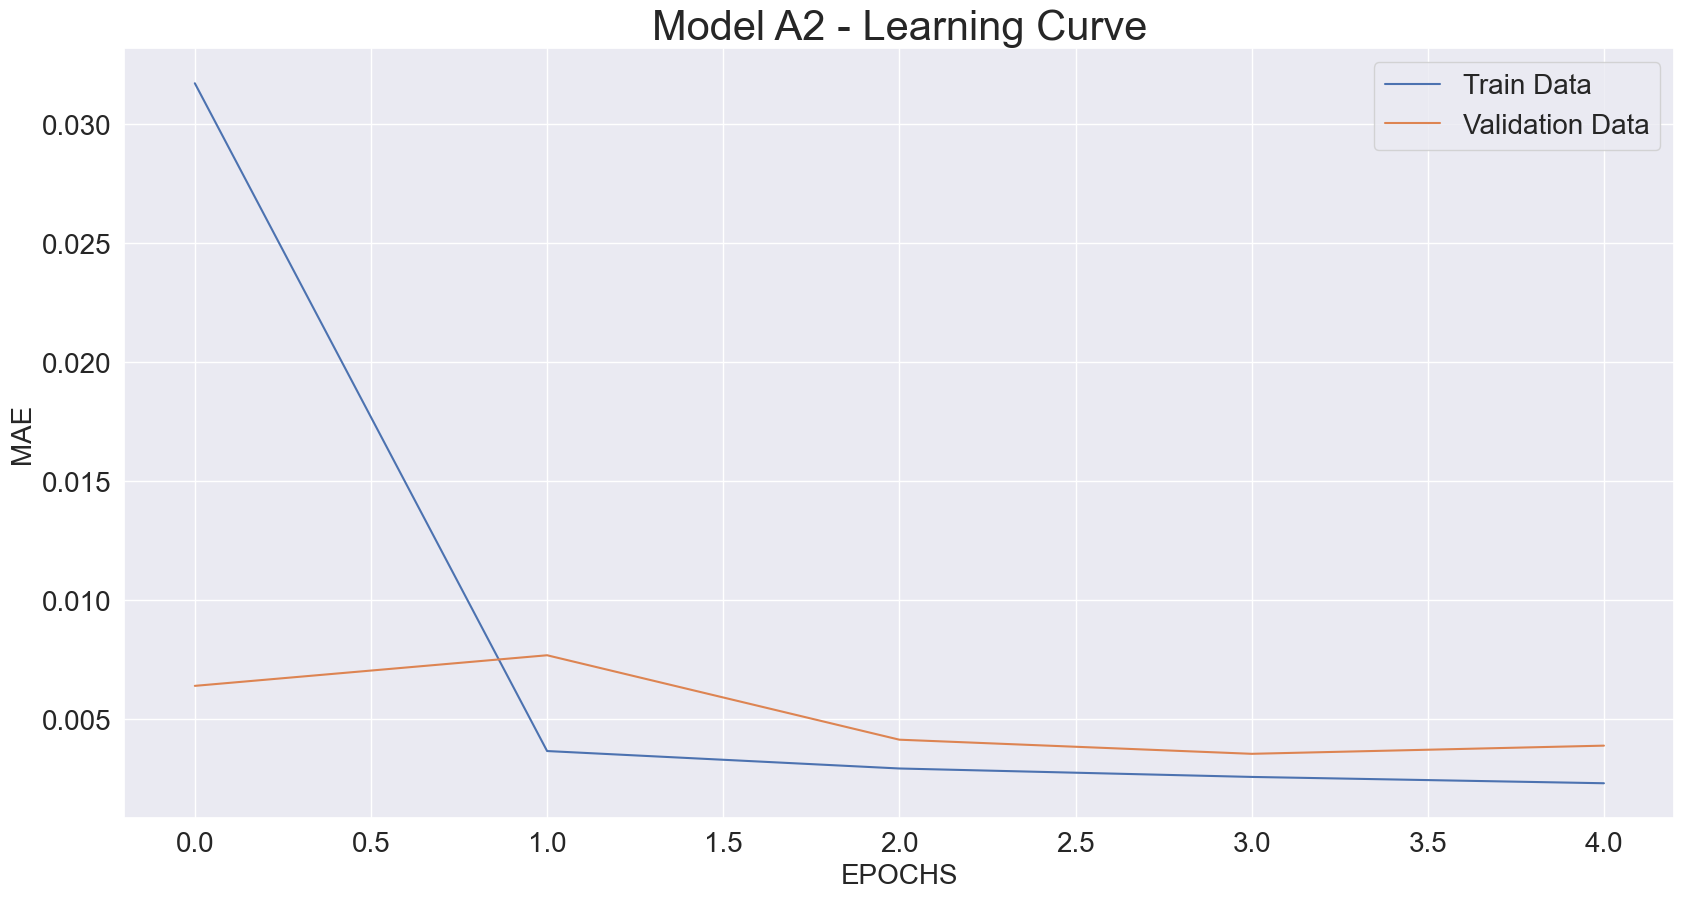

In [63]:

plotHistory(history, title="Model A2 - Learning Curve")

In [122]:

lstm_model.save('.\models\my_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [77]:
df = load_df
df = df.truncate(after=pd.Timestamp('2021-05-05 00:00:00+00:00'))
df


NameError: name 'load_df_other' is not defined

In [80]:

global_data, size_train_data = selectData(datframe=df) 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"

scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data)
y_train_data = createTargetVector(scaled_train_data)

scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)


In [83]:

lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_difflog_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data, epoch=20)      


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 40, 50)            10400     
                                                                 
 lstm_11 (LSTM)              (None, 25)                7600      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
77/77 [==============================] - 5s 29ms/step - loss: 1.5606e-04 - val_loss: 1.1469e-04
Epoch 2/20
77/77 [==============================] - 2s 21ms/step - loss: 1.4831e-04 - val_loss: 1.1400e-04
Epoch 3/20
77/77 [==============================] - 2s 21ms/step - loss: 1.4860e-04 - val_loss:

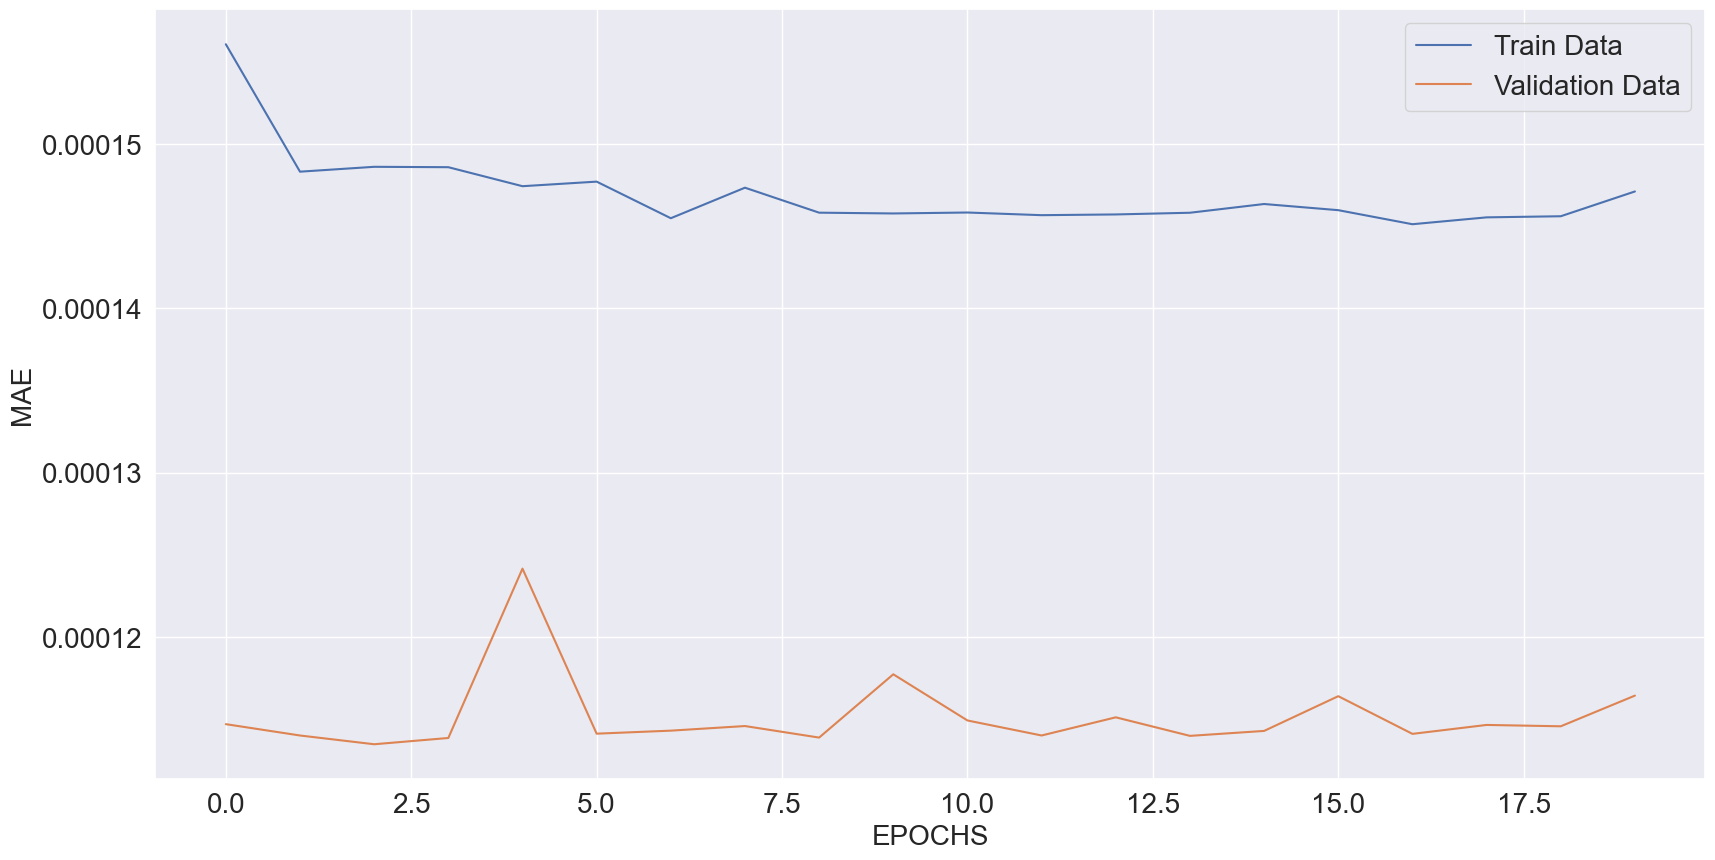

In [84]:
                        
plotHistory(history)



# == PREDICTIONS ==

##### Evaluate Predictions:

In [64]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

#### Plotting the results

In [65]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    if (not benchmark.empty):
        tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [66]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=30)
    plt.xlabel('Time', fontsize=15)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  

In [67]:
def plotPredictedPeriod (test_data, title,printBenchmark):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    if printBenchmark:
        plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=30)
    plt.xlabel('Time', fontsize=25)
    plt.ylabel('Closing Value',fontsize=25)
    #plt.legend(fontsize=20, loc=3)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()  


In [68]:
def plotResults(history=global_data, predicted="",benchmark=pd.DataFrame(), title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    #Only prints benchmark if not empty
    plotPredictedPeriod(tt_data,title,not benchmark.empty);


### Running Predictions

##### Linear Model

In [69]:
#Linear model
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 1s 0s/step


In [70]:
testPredictionsScore(test_data, predicted_stock_price)


Test Score: 85.05 RMSE


C:\Users\queir\AppData\Local\Temp\ipykernel_21452\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


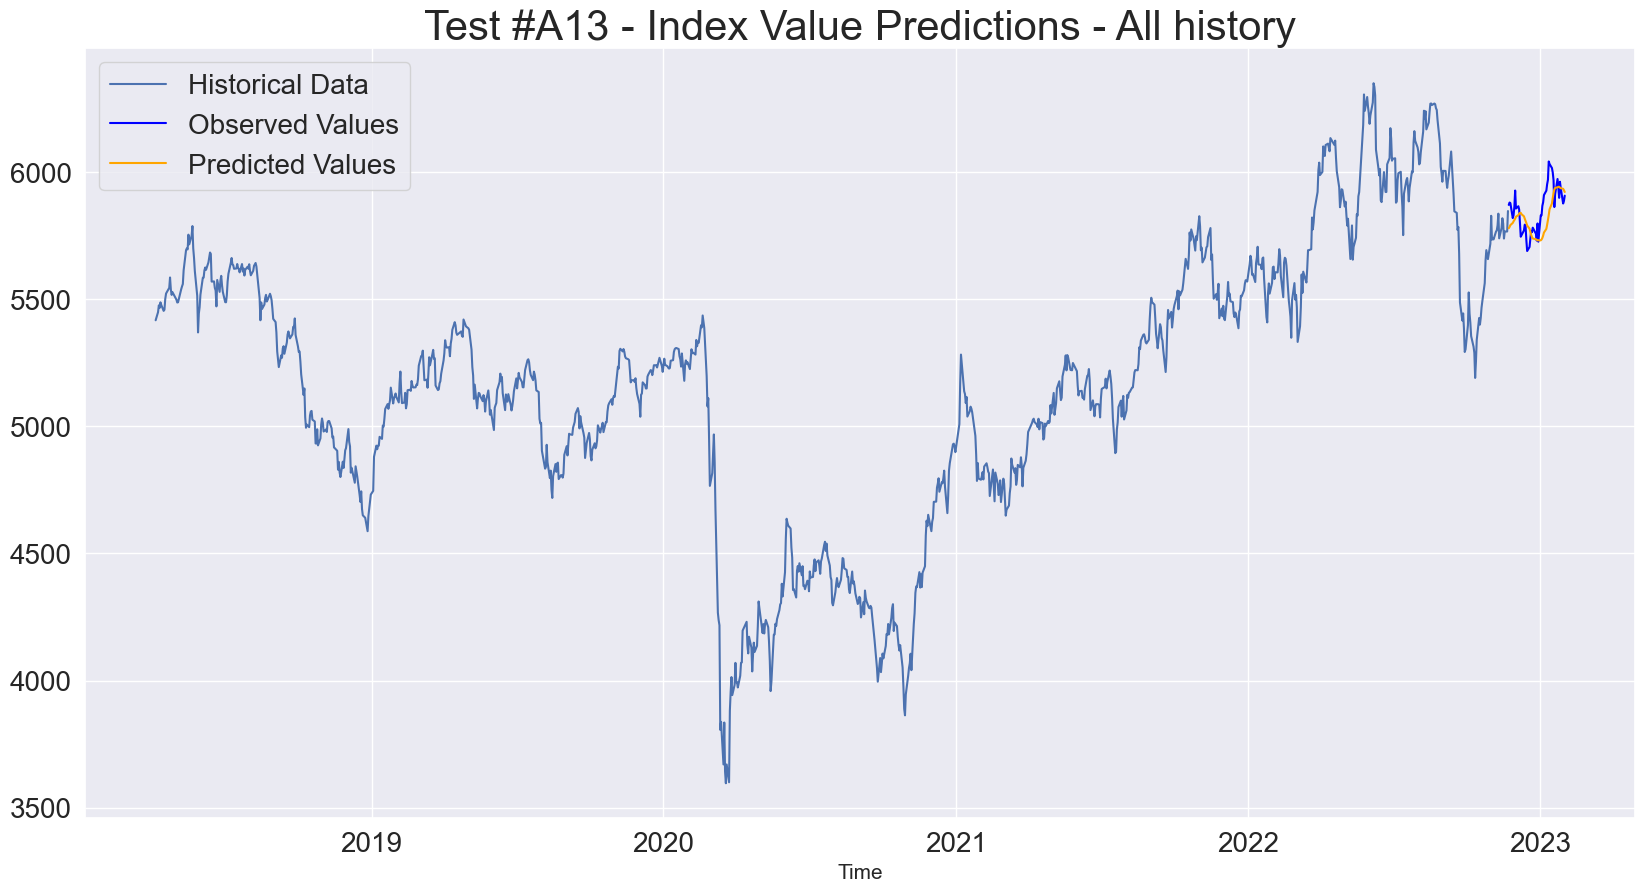

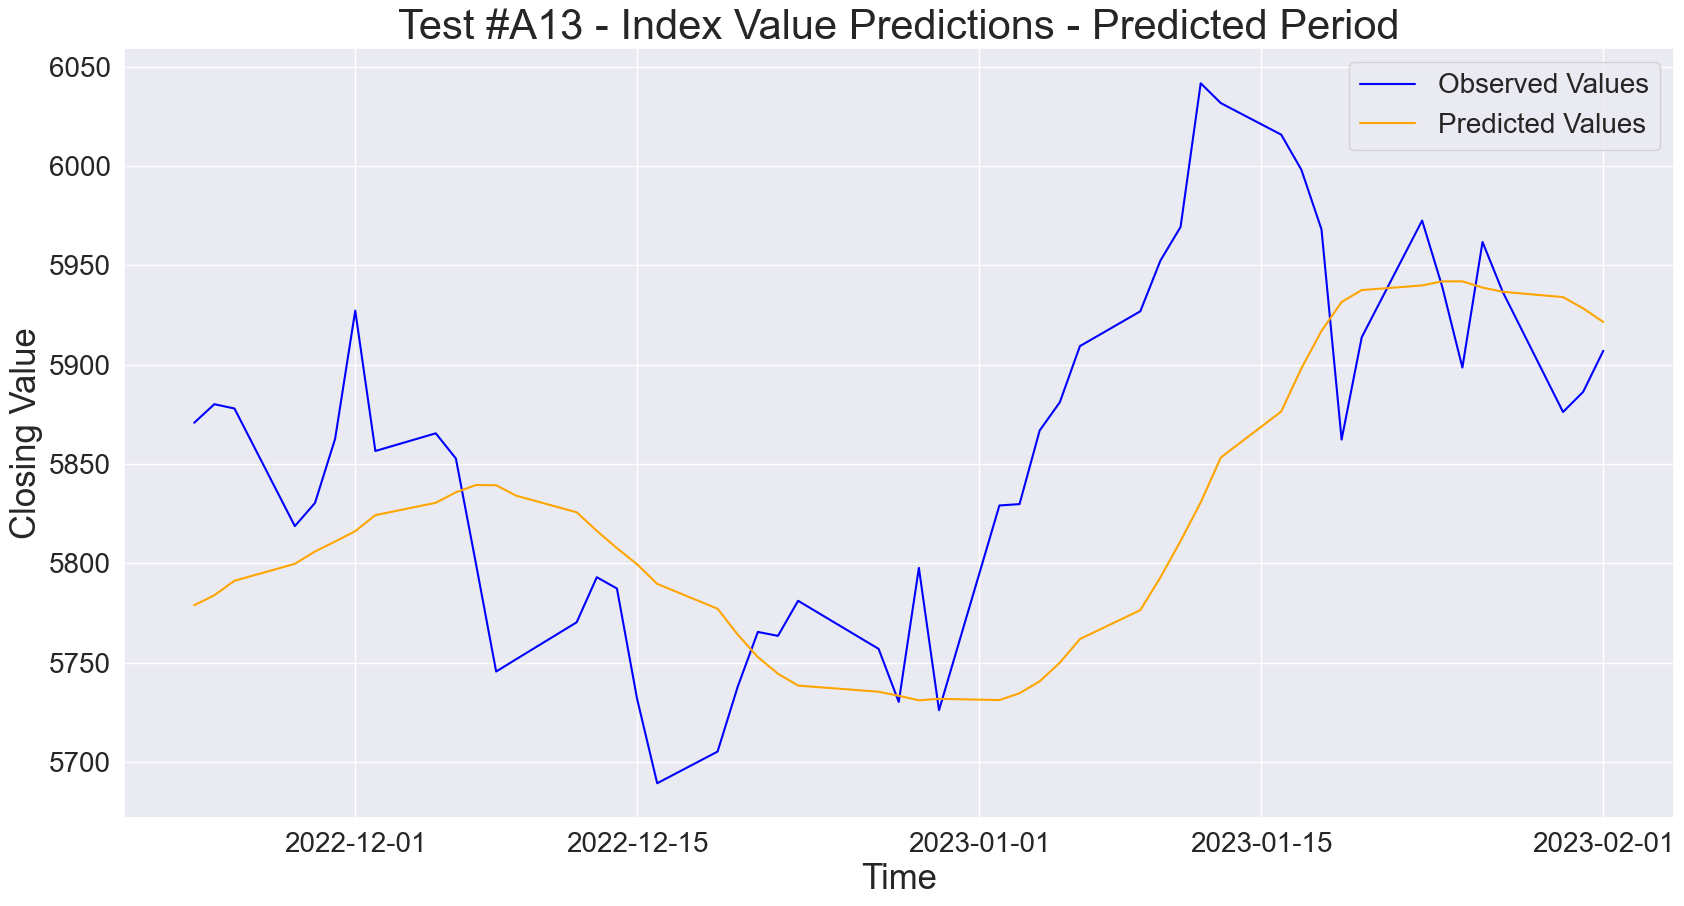

In [71]:
plotResults(predicted=predicted_stock_price, title="Test #A13 - Index Value Predictions")

##### DiffLog Model


In [85]:
#Difflog Model
diff_logged_predictions=lstm_difflog_model.predict(X_test)

2/2 [==============================] - 1s 0s/step


In [88]:
#This is the correct one
predicted_stock_price = undiffLogData(test_data[LOOK_BACK:], diff_logged_predictions);


In [89]:
testPredictionsScore(test_data, predicted_stock_price)
#testDayBeforeScore()

Test Score: 42.41 RMSE


C:\Users\queir\AppData\Local\Temp\ipykernel_21452\2412142912.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if (type=="categorical"):


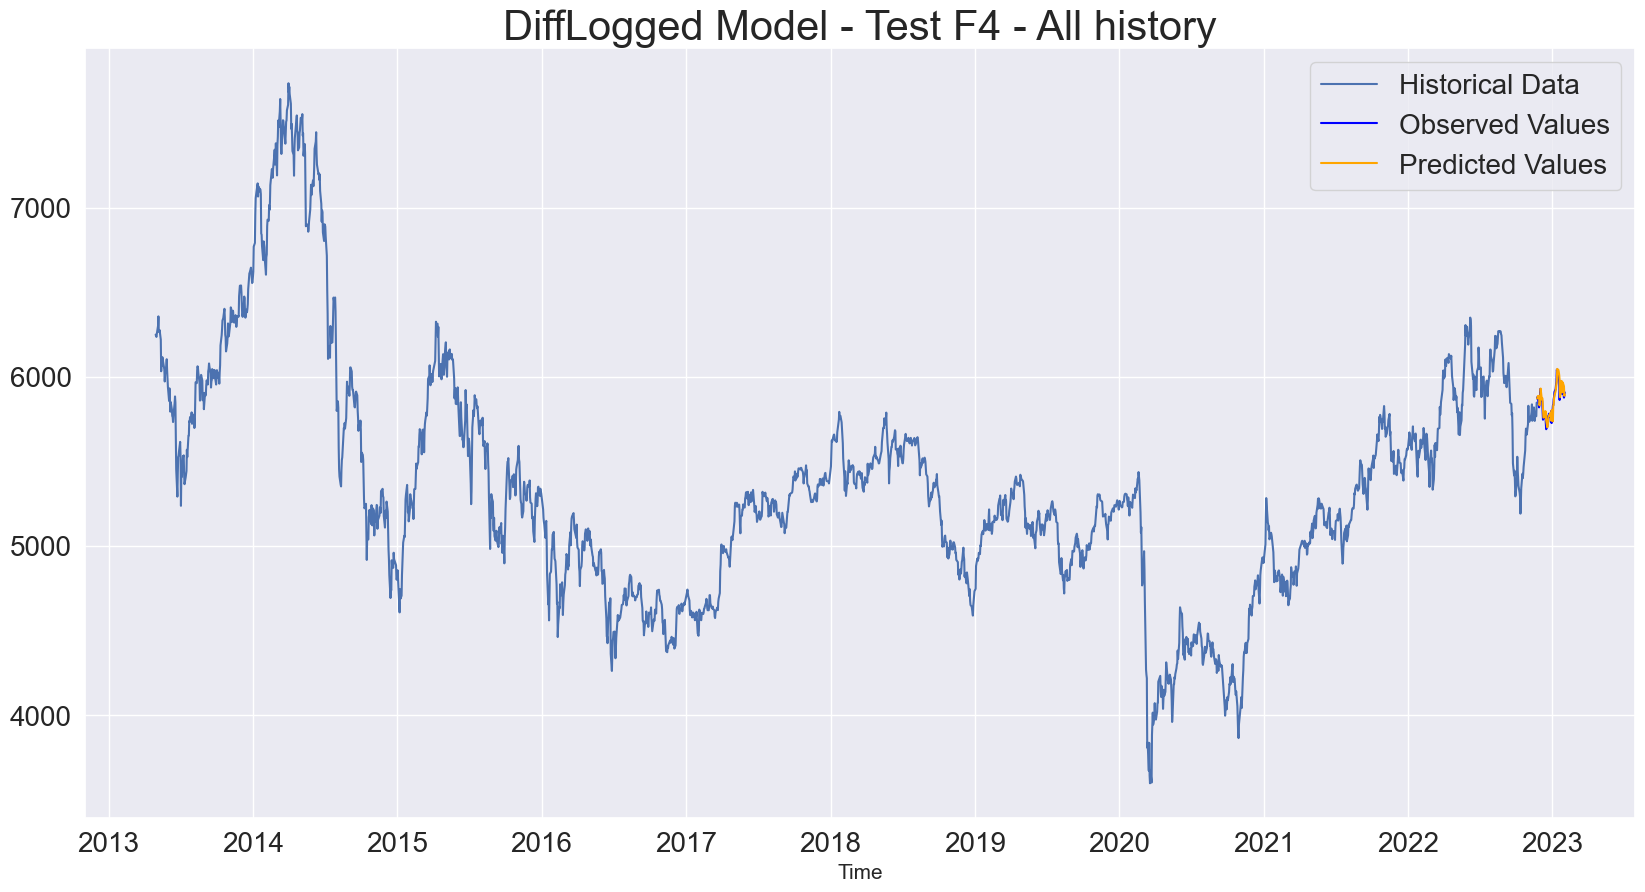

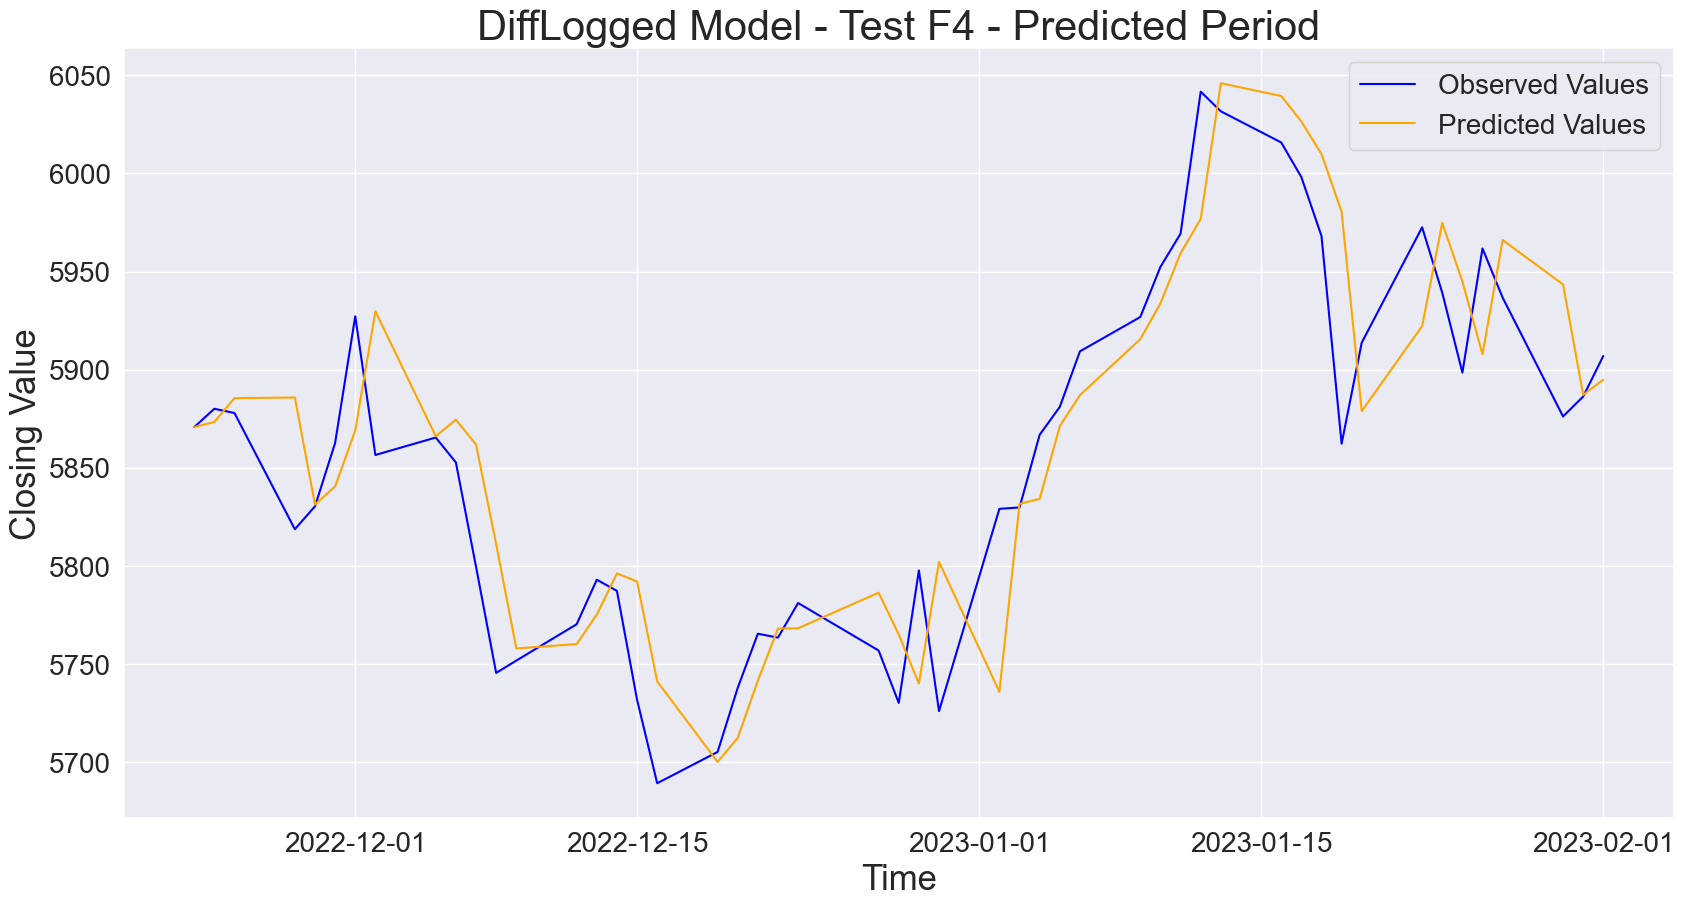

In [93]:
plotResults(history=global_data, predicted=predicted_stock_price, title="DiffLogged Model - Test F4")

# Clear All

In [140]:
globals().clear()


<function dict.clear>